In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

c:\users\zeel\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
c:\users\zeel\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in Nu

In [3]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [5]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

  'concern', '.', '"', 'the', 'challenge', 'for', 'our', 'industry', 'is', 'to', 'keep', 'from',
  'getting', 'carried', 'away', 'and', 'repeating', 'past', 'mistakes', ',"', 'gaf', "'", 's',
  'heyman', 'cautioned', '.', '"', 'the', 'shift', 'from', 'commodity', 'chemicals', 'may', 'be',
  'ill', '-', 'advised', '.', 'specialty', 'businesses', 'do', 'not', 'stay', 'special', 'long',
  '."', 'houston', '-', 'based', 'cain', 'chemical', ',', 'created', 'this', 'month', 'by', 'the',
  'sterling', 'investment', 'banking', 'group', ',', 'believes', 'it', 'can', 'generate', '700',
  'mln', 'dlrs', 'in', 'annual', 'sales', 'by', 'bucking', 'the', 'industry', 'trend', '.',
  'chairman', 'gordon', 'cain', ',', 'who', 'previously', 'led', 'a', 'leveraged', 'buyout', 'of',
  'dupont', "'", 's', 'conoco', 'inc', "'", 's', 'chemical', 'business', ',', 'has', 'spent', '1',
  '.', '1', 'billion', 'dlrs', 'since', 'january', 'to', 'buy', 'seven', 'petrochemical', 'plants',
  'along', 'the', 'texas', 

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    
    corpora = [*map(set, corpus)]
    corpus_words = sorted([*set().union(*corpora)])
    num_corpus_words = len(corpus_words)

    # ------------------

    return corpus_words, num_corpus_words

In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    
    # Get distinct words first
    distincts, n = distinct_words(corpus)
    
    # map distinct words to an ordered index
    for i in range(n):
        word2Ind[distincts[i]] = i
    
    M = np.zeros((n, n))
    for sentence in corpus:
        for w in range(len(sentence)):
            curr = sentence[w]
            neighbors = sentence[max(0, w-window_size) : min(len(sentence), w+window_size+1)]
            
            # add the neighbors to M
            for n in neighbors:
                M[word2Ind[curr]][word2Ind[n]] += 1
            
            # since neighbors list includes self, subtract self 
            M[word2Ind[curr]][word2Ind[curr]] -= 1

    # ------------------

    return M, word2Ind

In [5]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k)

    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [6]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    # simulating a pandas df['type'] column
    
    for word in words:
        x = M_reduced[word2Ind[word]][0]
        y = M_reduced[word2Ind[word]][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+0.0001, y+0.0001, word, fontsize=20)
    plt.show()

    # ------------------

Running Truncated SVD over 8185 words...
Done.


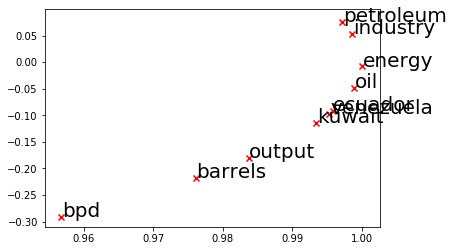

In [9]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

In [10]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    return wv_from_bin

In [11]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_word2vec()

In [14]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [15]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...


c:\users\zeel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
c:\users\zeel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).


Done.


In [16]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))


[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]


In [17]:
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'sexually_assualted'], negative=['woman']))

[('Alleged_rapist', 0.6001197099685669),
 ('forcibly_sodomized', 0.5902889966964722),
 ('alleged_stabber', 0.57771897315979),
 ('Escaped_prisoner', 0.5742642879486084),
 ('horribly_horribly_deranged', 0.573653519153595),
 ('impersonating_cop', 0.5663542747497559),
 ('Teenager_stabbed', 0.5643482208251953),
 ('Alleged_kidnapper', 0.5600510239601135),
 ('Victim_testifies', 0.5587233304977417),
 ('brandished_screwdriver', 0.5584416389465332)]


In [18]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'sexually_assualted'], negative=['man']))


[('raped', 0.62529057264328),
 ('sexually_assaulted', 0.6097201704978943),
 ('forcibly_raped', 0.6081056594848633),
 ('Parents_Slain_anchorwoman', 0.6078684329986572),
 ('buys_bagged_spinach', 0.5899451375007629),
 ('indecently_touched', 0.5826438665390015),
 ('Sexually_abused', 0.5793202519416809),
 ('digitally_penetrated', 0.5777840614318848),
 ('sexually_fondled', 0.576257050037384),
 ('forcibly_fondled', 0.5762069225311279)]


In [19]:
pprint.pprint(wv_from_bin.most_similar(positive=['USA', 'Narendra_Modi'], negative=['India']))


[('Rima_Fakih_Miss', 0.41361546516418457),
 ('lifts_Squaw_Valley', 0.3881469964981079),
 ('Tara_Conner_Miss', 0.3869706392288208),
 ('FINAL_FOUR', 0.3863060474395752),
 ('HELPING_PEOPLE', 0.38622111082077026),
 ('proudly_proclaims_Made', 0.38356101512908936),
 ('DUBYA', 0.383062481880188),
 ('KONICA_MINOLTA_PRINTING_SOLUTIONS', 0.37637123465538025),
 ('NAZI', 0.3740931749343872),
 ('ANNOUNCING_THE', 0.37391141057014465)]
